# Main notebook for Bayesball

Main notebook for Bayesball analysis. Ongoing clean-up in progress. Most sections have been moved to indivudal .py files. Not the best way to do it but it makes this notebook clean. The figures/analysis for the paper can all be found in this notebook.

In [1]:
# Libraries - needs some cleaning up
from IPython.display import HTML
import os
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import pybaseball
pybaseball.cache.enable()
from pybaseball import statcast, playerid_lookup, playerid_reverse_lookup, statcast_pitcher
from pybaseball import lahman
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from IPython.core.debugger import set_trace
import concurrent.futures
import time
import pickle 
from tqdm import tqdm
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Define helper function
These are just stored in .py file for now and run directly. I have not converted into a module yet for direct importing. 

In [2]:
%run -i "code/helper_functions.py"

# Process data for analysis
### This is the main section for getting the data

In [3]:
# Either load data or gather using pybaseball
load_data = True # False #

%run -i "code/analyze_data.py"

# Figure 1 OLD
This figure is no longer in use. This is the original Figure 1, which has since been removed and replaced. Keeping it here for reference and to show how its made mostly in python

/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(


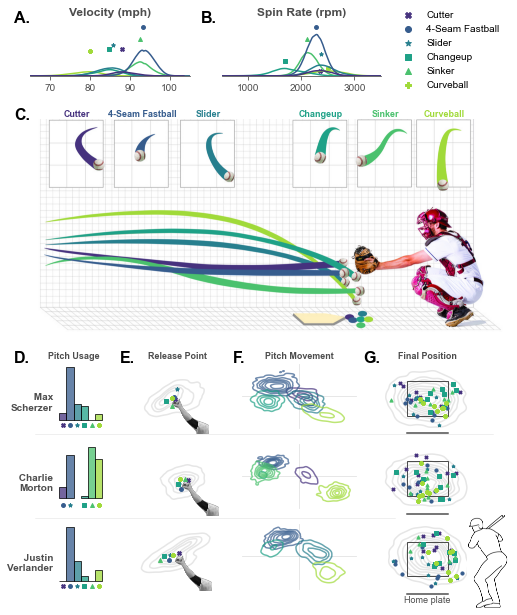

In [4]:
%run -i "code/figure1-v1.py"

# Plots for Figure 1 V2 - TODO: Fix pandas indexing issue
The v2 figure 1 is made in inkscape, but the data figures are made here. The figures are mostly formatted for use in inkscape so they are missing axis labels, titles, etc.

/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


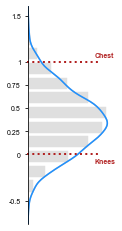

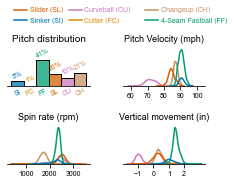

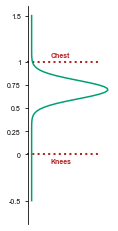

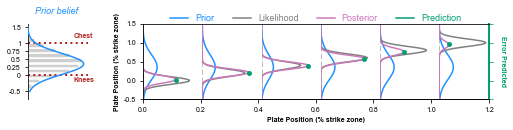

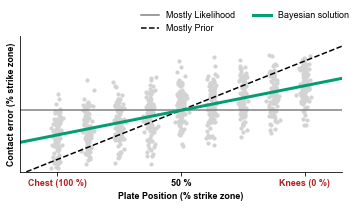

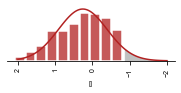

/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


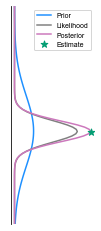

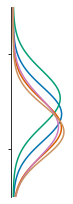

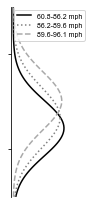

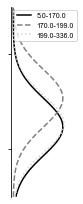

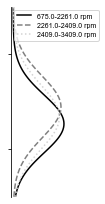

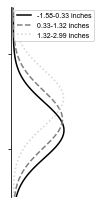

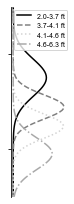

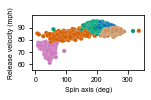

In [6]:
%run -i "code/figure1-v2.py"

# Main results - figure 2 in paper

In [ ]:
# This needs to be run first to analyze the data on a per pitcher basis. 
%run -i "code/data_by_pitcher.py"

Performing regression for each pitch and for each individual pitcher ... 


100%|██████████| 1881/1881 [01:02<00:00, 30.23it/s]
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/scipy/stats/stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


nan


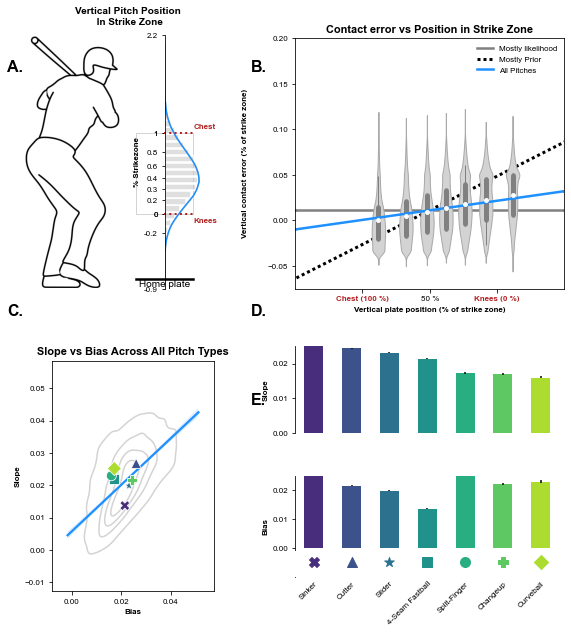

In [8]:
# This builds the figure
%run -i "code/figure2-v1.py"

# Pitch tipping - get data and plot

/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


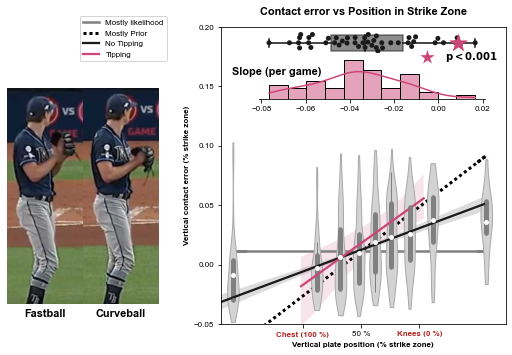

T-value =  -11.671811688617145 ; T-critical =  2.0128955952945886 ; P-val =  2.3849347033305288e-15


In [11]:
%run -i "code/pitch_tipping.py"

# Knuckleball and Eephus section

/Users/justinbrantley/Dropbox/KLAB/Projects/Bayesball/_Bayesball (on github)/code/eephus_and_knuckleball.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(["Knees (0 %)", "50 %", "Chest (100 %)"])


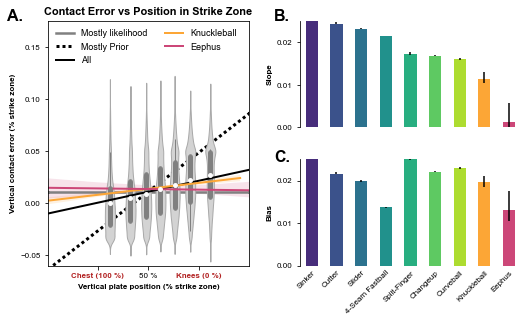

In [10]:
%run -i "code/eephus_and_knuckleball.py"